Evolving t₁=1.0, t₂=2.0: 100%|██████████| 400000/400000 [4:45:41<00:00, 23.33it/s]      


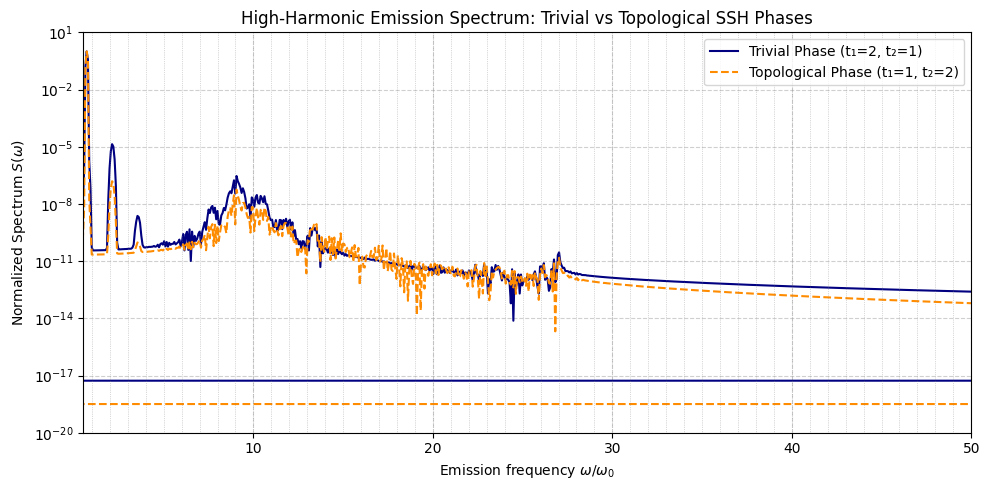

In [ ]:
import numpy as np
from math import sin, cos, sqrt, pi
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1D SSH Model
class One_D_SSH_Fast_Model:
    def __init__(self, t1=1.0, t2=2.0, amp=0.5, nc=10, number_points_k=251, dt=0.001):
        """Fast 1D SSH Model with time evolution using eigen-decomposition."""
        self.t1 = t1
        self.t2 = t2
        self.amp = amp
        self.nc = nc
        self.dt = dt
        self.number_points_k = number_points_k

        # frequency and total time
        self.omega = np.pi / (2.0 * nc)
        self.t_max = 2.0 * np.pi * nc / self.omega
        self.time = np.linspace(0.0, self.t_max, int(self.t_max / self.dt), endpoint=False)

        # momentum grid
        self.KK = np.linspace(-np.pi, np.pi, number_points_k, endpoint=False)
        self.dk = 2.0 * np.pi / number_points_k

        # initial density matrix: lower band occupied
        self.rho_thermal = np.array([[0, 0], [0, 1]], dtype=complex)

    def Ax(self, t: float):
        """Time-dependent vector potential A(t)."""
        return self.amp * sin(self.omega * t) * (sin(self.omega * t / (2.0 * self.nc))) ** 2

    def H(self, k: float, At: float):
        """Time-dependent Hamiltonian matrix for given momentum k and field A(t)."""
        t1, t2 = self.t1, self.t2
        denom = sqrt(t1**2 + t2**2 + 2 * t1 * t2 * cos(k))
        Hpp = (t2**2 * cos(At) + t1**2 + t1 * t2 * (cos(k) + cos(k - At))) / denom
        Hmm = -Hpp
        Hpm = 1j * t2 * (t2 * sin(At) + t1 * (sin(k) - sin(k - At))) / denom
        Hmp = np.conj(Hpm)
        return np.array([[Hpp, Hpm], [Hmp, Hmm]], dtype=complex)

    def current_matrix(self, k: float, At: float):
        """Current operator matrix for given momentum k and field A(t)."""
        t1, t2 = self.t1, self.t2
        denom = sqrt(t1**2 + t2**2 + 2 * t1 * t2 * cos(k))
        diag = t2 * (t2 * sin(At) - t1 * sin(k - At)) / denom
        non_diag = -1.0j * t2 * (t2 * cos(At) + t1 * cos(k - At)) / denom
        return np.array([[diag, non_diag], [-non_diag, -diag]], dtype=complex)

    def average_current(self):
        """Compute ⟨J(t)⟩ averaged over the Brillouin zone."""
        Nt = len(self.time)
        Nk = self.number_points_k
        dt = self.dt
        dk = self.dk

        rho_k = np.tile(self.rho_thermal, (Nk, 1, 1)).astype(complex)
        avg_current = np.zeros(Nt)

        for n in tqdm(range(Nt), desc=f"Evolving t₁={self.t1}, t₂={self.t2}"):
            t = self.time[n]
            At = self.Ax(t)
            j_total = 0.0

            for i, k in enumerate(self.KK):
                H = self.H(k, At)
                evals, evecs = np.linalg.eigh(H)
                U = evecs @ np.diag(np.exp(-1j * evals * dt)) @ evecs.conj().T
                rho_k[i] = U @ rho_k[i] @ U.conj().T
                J = self.current_matrix(k, At)
                j_total += np.trace(J @ rho_k[i]).real * dk / (2.0 * np.pi)

            avg_current[n] = j_total

        return avg_current


#Frequency-Domain Emission Spectrum

def compute_spectrum(model, jx):
    """
    Compute emission spectrum S(ω) from time-domain current jx(t)
    using FFT and normalize it.
    """
    dt = model.dt
    omega0 = 2 / 9.01  # from the problem statement
    freq = 2 * np.pi * np.fft.fftfreq(len(jx), dt) / omega0  # normalized ω/ω0
    Jw = np.fft.fft(jx)
    S_omega = np.abs(Jw)**2
    return freq, S_omega / np.max(S_omega)

# Main Execution and Plot
if __name__ == "__main__":
    # Trivial and topological phases
    model_triv = One_D_SSH_Fast_Model(t1=2.0, t2=1.0, amp=0.5)
    j_triv = model_triv.average_current()

    model_topo = One_D_SSH_Fast_Model(t1=1.0, t2=2.0, amp=0.5)
    j_topo = model_topo.average_current()

    # Compute spectra
    freq_triv, S_triv = compute_spectrum(model_triv, j_triv)
    freq_topo, S_topo = compute_spectrum(model_topo, j_topo)

    # Plot Emission Spectrum (S(ω))
    plt.figure(figsize=(10, 5))
    plt.semilogy(freq_triv, S_triv, label="Trivial Phase (t₁=2, t₂=1)", color="navy")
    plt.semilogy(freq_topo, S_topo, '--', label="Topological Phase (t₁=1, t₂=2)", color="darkorange")

    plt.xlim(0.5, 50)
    plt.ylim(1e-20, 1e1)
    plt.xlabel(r"Emission frequency $\omega / \omega_0$")
    plt.ylabel(r"Normalized Spectrum $S(\omega)$")
    plt.title("High-Harmonic Emission Spectrum: Trivial vs Topological SSH Phases")
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.6)

    # Vertical lines for harmonic orders
    for n in range(1, 51):
        plt.axvline(n, color='gray', ls=':', lw=0.5, alpha=0.6)

    plt.tight_layout()
    plt.show()



In [ ]:
import numpy as np
from math import sin, cos, sqrt, pi
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1D SSH Model
class One_D_SSH_Fast_Model:
    def __init__(self, t1=1.0, t2=2.0, amp=0.5, nc=10, number_points_k=251, dt=0.001):
        """Fast 1D SSH Model with time evolution using eigen-decomposition."""
        self.t1 = t1
        self.t2 = t2
        self.amp = amp
        self.nc = nc
        self.dt = dt
        self.number_points_k = number_points_k

        # frequency and total time
        self.omega = np.pi / (2.0 * nc)
        self.t_max = 2.0 * np.pi * nc / self.omega
        self.time = np.linspace(0.0, self.t_max, int(self.t_max / self.dt), endpoint=False)

        # momentum grid
        self.KK = np.linspace(-np.pi, np.pi, number_points_k, endpoint=False)
        self.dk = 2.0 * np.pi / number_points_k

        # initial density matrix: lower band occupied
        self.rho_thermal = np.array([[0, 0], [0, 1]], dtype=complex)

    def Ax(self, t: float):
        """Time-dependent vector potential A(t)."""
        return self.amp * sin(self.omega * t) * (sin(self.omega * t / (2.0 * self.nc))) ** 2

    def H(self, k: float, At: float):
        """Time-dependent Hamiltonian matrix for given momentum k and field A(t)."""
        t1, t2 = self.t1, self.t2
        denom = sqrt(t1**2 + t2**2 + 2 * t1 * t2 * cos(k))
        Hpp = (t2**2 * cos(At) + t1**2 + t1 * t2 * (cos(k) + cos(k - At))) / denom
        Hmm = -Hpp
        Hpm = 1j * t2 * (t2 * sin(At) + t1 * (sin(k) - sin(k - At))) / denom
        Hmp = np.conj(Hpm)
        return np.array([[Hpp, Hpm], [Hmp, Hmm]], dtype=complex)

    def current_matrix(self, k: float, At: float):
        """Current operator matrix for given momentum k and field A(t)."""
        t1, t2 = self.t1, self.t2
        denom = sqrt(t1**2 + t2**2 + 2 * t1 * t2 * cos(k))
        diag = t2 * (t2 * sin(At) - t1 * sin(k - At)) / denom
        non_diag = -1.0j * t2 * (t2 * cos(At) + t1 * cos(k - At)) / denom
        return np.array([[diag, non_diag], [-non_diag, -diag]], dtype=complex)


# Correct Spectrum Computation
def compute_spectrum_correct(model):
    """
    Compute emission spectrum S(ω) correctly:
    1. Fourier transform J_k(t)
    2. Take |J_k(ω)|²
    3. Sum over k (Brillouin zone)
    4. Return normalized spectrum vs ω/ω0
    """
    dt = model.dt
    omega0 = 2 / 9.01
    Nk = model.number_points_k
    Nt = len(model.time)

    # Initialize storage for time-dependent current per k
    j_k_t = np.zeros((Nk, Nt), dtype=complex)
    rho_k = np.tile(model.rho_thermal, (Nk, 1, 1)).astype(complex)

    for n, t in enumerate(tqdm(model.time, desc="Time evolution for spectrum")):
        At = model.Ax(t)
        for i, k in enumerate(model.KK):
            H = model.H(k, At)
            evals, evecs = np.linalg.eigh(H)
            U = evecs @ np.diag(np.exp(-1j * evals * dt)) @ evecs.conj().T
            rho_k[i] = U @ rho_k[i] @ U.conj().T
            J = model.current_matrix(k, At)
            j_k_t[i, n] = np.trace(J @ rho_k[i])

    #Step 1–2: Fourier transform each k, take |...|²
    Jk_w = np.fft.fft(j_k_t, axis=1)
    S_k_w = np.abs(Jk_w)**2

    #Step 3: integrate over k
    S_omega = np.sum(S_k_w, axis=0) * model.dk / (2 * np.pi)

    #Step 4: normalize and compute freq axis
    freq = 2 * np.pi * np.fft.fftfreq(Nt, dt) / omega0
    S_omega /= np.max(S_omega)

    return freq, S_omega


# Main Execution and Plotting
if __name__ == "__main__":
    # Trivial and topological phases
    model_triv = One_D_SSH_Fast_Model(t1=2.0, t2=1.0, amp=0.5)
    freq_triv, S_triv = compute_spectrum_correct(model_triv)

    model_topo = One_D_SSH_Fast_Model(t1=1.0, t2=2.0, amp=0.5)
    freq_topo, S_topo = compute_spectrum_correct(model_topo)

    # Plot Emission Spectrum (S(ω))
    plt.figure(figsize=(10, 5))
    plt.semilogy(freq_triv, S_triv, label="Trivial Phase (t₁=2, t₂=1)", color="navy")
    plt.semilogy(freq_topo, S_topo, '--', label="Topological Phase (t₁=1, t₂=2)", color="darkorange")

    plt.xlim(0.5, 50)
    plt.ylim(1e-15, 1e1)
    plt.xlabel(r"Emission frequency $\omega / \omega_0$")
    plt.ylabel(r"Normalized Spectrum $S(\omega)$")
    plt.title("High-Harmonic Emission Spectrum: Correct Fourier Order")
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.6)

    # Vertical lines for harmonic orders
    for n in range(1, 51):
        plt.axvline(n, color='gray', ls=':', lw=0.5, alpha=0.6)

    plt.tight_layout()
    plt.show()


Time evolution for spectrum: 100%|██████████| 400000/400000 [1:48:09<00:00, 61.64it/s]  


MemoryError: Unable to allocate 766. MiB for an array with shape (251, 400000) and data type float64

Summing over k: 100%|██████████| 251/251 [1:57:10<00:00, 28.01s/it]
c:\Users\zimme\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


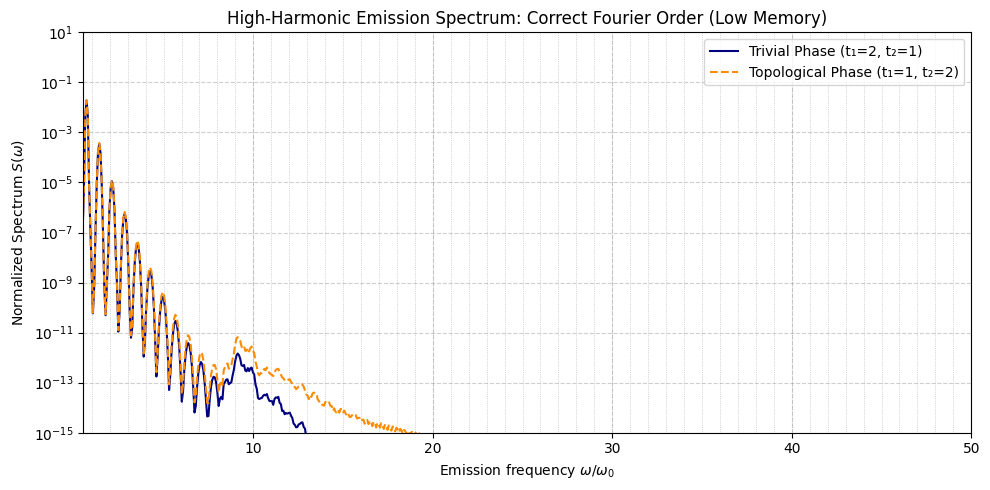

In [ ]:
import numpy as np
from math import sin, cos, sqrt, pi
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1D SSH Model
class One_D_SSH_Fast_Model:
    def __init__(self, t1=1.0, t2=2.0, amp=0.5, nc=10, number_points_k=251, dt=0.001):
        self.t1 = t1
        self.t2 = t2
        self.amp = amp
        self.nc = nc
        self.dt = dt
        self.number_points_k = number_points_k

        self.omega = np.pi / (2.0 * nc)
        self.t_max = 2.0 * np.pi * nc / self.omega
        self.time = np.linspace(0.0, self.t_max, int(self.t_max / self.dt), endpoint=False)

        self.KK = np.linspace(-np.pi, np.pi, number_points_k, endpoint=False)
        self.dk = 2.0 * np.pi / number_points_k
        self.rho_thermal = np.array([[0, 0], [0, 1]], dtype=complex)

    def Ax(self, t):
        return self.amp * sin(self.omega * t) * (sin(self.omega * t / (2.0 * self.nc))) ** 2

    def H(self, k, At):
        t1, t2 = self.t1, self.t2
        denom = sqrt(t1**2 + t2**2 + 2 * t1 * t2 * cos(k))
        Hpp = (t2**2 * cos(At) + t1**2 + t1 * t2 * (cos(k) + cos(k - At))) / denom
        Hmm = -Hpp
        Hpm = 1j * t2 * (t2 * sin(At) + t1 * (sin(k) - sin(k - At))) / denom
        Hmp = np.conj(Hpm)
        return np.array([[Hpp, Hpm], [Hmp, Hmm]], dtype=complex)

    def current_matrix(self, k, At):
        t1, t2 = self.t1, self.t2
        denom = sqrt(t1**2 + t2**2 + 2 * t1 * t2 * cos(k))
        diag = t2 * (t2 * sin(At) - t1 * sin(k - At)) / denom
        non_diag = -1.0j * t2 * (t2 * cos(At) + t1 * cos(k - At)) / denom
        return np.array([[diag, non_diag], [-non_diag, -diag]], dtype=complex)

# Low-Memory Correct Spectrum Computation
def compute_spectrum_correct(model):
    """
    Memory-efficient emission spectrum:
    1. For each k, evolve ρ_k(t), compute J_k(t)
    2. FFT → |J_k(ω)|²
    3. Sum over k
    """
    dt = model.dt
    omega0 = 2 / 9.01
    Nk = model.number_points_k
    Nt = len(model.time)

    freq = 2 * np.pi * np.fft.fftfreq(Nt, dt) / omega0
    S_omega = np.zeros(Nt, dtype=float)

    for i, k in enumerate(tqdm(model.KK, desc="Summing over k")):
        rho = model.rho_thermal.copy()
        j_t = np.zeros(Nt, dtype=complex)

        for n, t in enumerate(model.time):
            At = model.Ax(t)
            H = model.H(k, At)
            evals, evecs = np.linalg.eigh(H)
            U = evecs @ np.diag(np.exp(-1j * evals * dt)) @ evecs.conj().T
            rho = U @ rho @ U.conj().T
            J = model.current_matrix(k, At)
            j_t[n] = np.trace(J @ rho)

        # FFT and add to spectrum
        Jw = np.fft.fft(j_t)
        S_omega += np.abs(Jw)**2 * model.dk / (2 * np.pi)

    # Normalize
    S_omega /= np.max(S_omega)

    return freq, S_omega


# Main Execution and Plotting
if __name__ == "__main__":
    model_triv = One_D_SSH_Fast_Model(t1=2.0, t2=1.0, amp=0.5)
    freq_triv, S_triv = compute_spectrum_correct(model_triv)

    model_topo = One_D_SSH_Fast_Model(t1=1.0, t2=2.0, amp=0.5)
    freq_topo, S_topo = compute_spectrum_correct(model_topo)

    plt.figure(figsize=(10, 5))
    plt.semilogy(freq_triv, S_triv, label="Trivial Phase (t₁=2, t₂=1)", color="navy")
    plt.semilogy(freq_topo, S_topo, '--', label="Topological Phase (t₁=1, t₂=2)", color="darkorange")

    plt.xlim(0.5, 50)
    plt.ylim(1e-15, 1e1)
    plt.xlabel(r"Emission frequency $\omega / \omega_0$")
    plt.ylabel(r"Normalized Spectrum $S(\omega)$")
    plt.title("High-Harmonic Emission Spectrum: Correct Fourier Order (Low Memory)")
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.6)

    for n in range(1, 51):
        plt.axvline(n, color='gray', ls=':', lw=0.5, alpha=0.6)

    plt.tight_layout()
    plt.show()


k-loop: 100%|██████████| 251/251 [1:34:50<00:00, 22.67s/it]


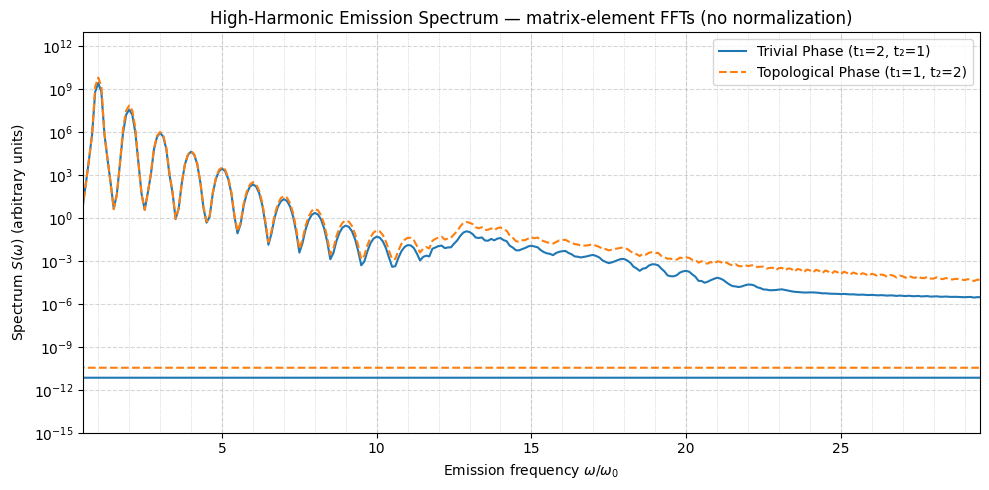

In [ ]:
import numpy as np
from math import sin, cos, sqrt, pi
from tqdm import tqdm
import matplotlib.pyplot as plt

#Model definition
class One_D_SSH_Fast_Model:
    def __init__(self, t1=1.0, t2=2.0, amp=0.5, nc=10, number_points_k=251, dt=0.001):
        self.t1 = t1
        self.t2 = t2
        self.amp = amp
        self.nc = nc
        self.dt = dt
        self.number_points_k = number_points_k

        # pumping frequency
        self.omega = np.pi / (2.0 * nc)

        # total pumping time and time grid
        self.t_max = 2.0 * np.pi * nc / self.omega
        # choose Nt as integer multiple: keep endpoint=False to match dt spacing
        self.time = np.linspace(0.0, self.t_max, int(self.t_max / self.dt), endpoint=False)

        # k-grid
        self.KK = np.linspace(-np.pi, np.pi, number_points_k, endpoint=False)
        self.dk = 2.0 * np.pi / number_points_k

        # initial density matrix: lower band occupied
        self.rho_thermal = np.array([[0, 0], [0, 1]], dtype=complex)

    def Ax(self, t: float):
        """Time-dependent vector potential A(t)."""
        return self.amp * sin(self.omega * t) * (sin(self.omega * t / (2.0 * self.nc))) ** 2

    def H(self, k: float, At: float):
        """Time-dependent Hamiltonian matrix (in eigenbasis of unperturbed system)."""
        t1, t2 = self.t1, self.t2
        denom = sqrt(t1**2 + t2**2 + 2 * t1 * t2 * cos(k))
        Hpp = (t2**2 * cos(At) + t1**2 + t1 * t2 * (cos(k) + cos(k - At))) / denom
        Hmm = -Hpp
        Hpm = 1j * t2 * (t2 * sin(At) + t1 * (sin(k) - sin(k - At))) / denom
        Hmp = np.conj(Hpm)
        return np.array([[Hpp, Hpm], [Hmp, Hmm]], dtype=complex)

    def current_matrix(self, k: float, At: float):
        """Current operator matrix for given momentum k and field A(t)."""
        t1, t2 = self.t1, self.t2
        denom = sqrt(t1**2 + t2**2 + 2 * t1 * t2 * cos(k))
        diag = t2 * (t2 * sin(At) - t1 * sin(k - At)) / denom
        non_diag = -1.0j * t2 * (t2 * cos(At) + t1 * cos(k - At)) / denom
        return np.array([[diag, non_diag], [-non_diag, -diag]], dtype=complex)


#Spectrum computation
def compute_spectrum_matrix_elements(model):
    """
    Compute S(omega) = (1/2pi) ∫_BZ dk sum_{n,m} | FFT_t[ (J_k(t) rho_k(t))_{n,m} ] |^2
    Memory-efficient: loop over k, for each k keep only four time-series (one per matrix element).
    Returns:
        freq: frequency axis (omega / omega0)
        S_omega: spectrum (no normalization by max)
    """
    dt = model.dt
    Nk = model.number_points_k
    Nt = len(model.time)

    # Use model.omega as the characteristic driving frequency omega0 if available,
    # otherwise fall back to 2/9.01 (kept for compatibility if desired).
    omega0 = getattr(model, "omega", 2.0 / 9.01)
    freq = 2.0 * np.pi * np.fft.fftfreq(Nt, dt) / omega0

    # accumulator for S(omega)
    S_omega = np.zeros(Nt, dtype=float)

    # pre-allocate the small arrays to avoid reallocating inside innermost loop
    # we store the 4 matrix element time series as:
    # m00_t, m01_t, m10_t, m11_t  (each length Nt)
    for i_k, k in enumerate(tqdm(model.KK, desc="k-loop")):
        # initialize rho for this k
        rho = model.rho_thermal.copy()

        # arrays for the 4 matrix elements (complex)
        m00_t = np.empty(Nt, dtype=complex)
        m01_t = np.empty(Nt, dtype=complex)
        m10_t = np.empty(Nt, dtype=complex)
        m11_t = np.empty(Nt, dtype=complex)

        # time evolution: fill matrix element time-series
        for n_t, t in enumerate(model.time):
            At = model.Ax(t)
            H = model.H(k, At)

            # propagate rho by a short time dt using instantaneous diagonalization (unitary)
            evals, evecs = np.linalg.eigh(H)
            U = evecs @ np.diag(np.exp(-1j * evals * dt)) @ evecs.conj().T
            rho = U @ rho @ U.conj().T

            # compute J and product M = J @ rho (keep full 2x2)
            J = model.current_matrix(k, At)
            M = J @ rho

            # store matrix elements (order: 00,01,10,11)
            m00_t[n_t] = M[0, 0]
            m01_t[n_t] = M[0, 1]
            m10_t[n_t] = M[1, 0]
            m11_t[n_t] = M[1, 1]

        # FFT each matrix element separately
        M00_w = np.fft.fft(m00_t)
        M01_w = np.fft.fft(m01_t)
        M10_w = np.fft.fft(m10_t)
        M11_w = np.fft.fft(m11_t)

        # power per element: |M_nm(omega)|^2
        P00 = np.abs(M00_w)**2
        P01 = np.abs(M01_w)**2
        P10 = np.abs(M10_w)**2
        P11 = np.abs(M11_w)**2

        # sum over matrix elements to get S_k(omega)
        S_k_omega = P00 + P01 + P10 + P11

        # add to global S(omega) with dk/(2pi)
        S_omega += S_k_omega * (model.dk / (2.0 * np.pi))

    return freq, S_omega


#Main execution & plotting
if __name__ == "__main__":
    # Trivial and topological phases (use specified t1,t2)
    model_triv = One_D_SSH_Fast_Model(t1=2.0, t2=1.0, amp=0.5, nc=10, number_points_k=251, dt=0.001)
    freq_triv, S_triv = compute_spectrum_matrix_elements(model_triv)

    model_topo = One_D_SSH_Fast_Model(t1=1.0, t2=2.0, amp=0.5, nc=10, number_points_k=251, dt=0.001)
    freq_topo, S_topo = compute_spectrum_matrix_elements(model_topo)

    # Plot Emission Spectrum (S(ω))
    plt.figure(figsize=(10, 5))
    plt.semilogy(freq_triv, S_triv, label="Trivial Phase (t₁=2, t₂=1)")
    plt.semilogy(freq_topo, S_topo, '--', label="Topological Phase (t₁=1, t₂=2)")

    plt.xlim(0.5, 29.5)   
    plt.ylim(1e-15, None)
    plt.xlabel(r"Emission frequency $\omega / \omega_0$")
    plt.ylabel(r"Spectrum $S(\omega)$ (arbitrary units)")
    plt.title("High-Harmonic Emission Spectrum — matrix-element FFTs (no normalization)")
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.5)

    #vertical harmonic markers
    for n in range(1, 31):
        plt.axvline(n, color='gray', ls=':', lw=0.5, alpha=0.5)

    plt.tight_layout()
    plt.show()
